## Building LLaMA 3 LLM From Scratch

This is an adapted version of [this tutorial](https://github.com/FareedKhan-dev/Building-llama3-from-scratch/tree/main).  

## Table of content

1. [Set up](#scrollTo=hX4IxgoDsy4D)

2. [Understanding the model files](#scrollTo=4W1Z1awCsy4G)

3. [Tokenizer](#scrollTo=uRBAlqs5sy4I)

4. [Word embedding](#scrollTo=MyGEk_bLsy4Q)

5. [RMSNorm](#scrollTo=OqPaG1wTsy4Q)

6. [Self-Attention module](#scrollTo=B0EdDC0TtSOS)

>[TODO 1 - Single head attention](#scrollTo=K1-HGbQ0OQgO)

7. [SwiGLU Activation Function](#scrollTo=satelrlWsy4V)

8. [Merging everything](#scrollTo=d5moBogysy4W)

9. [Generating the Output](#scrollTo=7rF_Zhipsy4W)

10. [TODO 2 - greedy decoding](#scrollTo=_WwLQiQc0blV)



## Set up

In [ ]:
!pip install --quiet sentencepiece tiktoken torch blobfile matplotlib huggingface_hub umap-learn ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.5 MB/s eta 0:00:00


After installing the required libraries, we need to download some files. Since we're going to replicate the architecture of llama-3–8B, you must have an account on HuggingFace. Additionally, since llama-3 is a gated model, you have to accept their terms and conditions to access model content.

Here are the steps:
1. Create an HuggingFace account from this [link](https://huggingface.co/join?next=%2Fmeta-llama%2FMeta-Llama-3-8B)
2. Accept the terms and conditions of llama-3–8B from this [link](https://huggingface.co/meta-llama/Meta-Llama-3-8B)

Once you've completed both of these steps, now we can download the files.  
Here are the steps:  
1. Log in to HuggingFace Hub on this notebook. You can create a new token or access it from this [link](https://huggingface.co/settings/tokens).
2. Download all relevant config/weights with snapshot_download

In [ ]:
from huggingface_hub import snapshot_download, notebook_login
notebook_login() # paste your huggingface token


In [ ]:
snapshot_download(repo_id="meta-llama/Meta-Llama-3-8B", local_dir='./Llama3-8b', ignore_patterns=['*.pth'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/7.80k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/36.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

USE_POLICY.md:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

original/params.json:   0%|          | 0.00/211 [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

'/content/Llama3-8b'

Once all the files are downloaded, we need to import the libraries that we will be using throughout this blog.

In [ ]:
# File system paths
from pathlib import Path
# Tokenization library
import tiktoken
# BPE loading function
from transformers import AutoTokenizer
# PyTorch library
import torch
# JSON handling
import json
# Plotting library
import matplotlib.pyplot as plt

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Next, we need to understand what each file will be used for.

## Understanding the model files

### 1. tokenizer.json, tokenizer_config.json, special_tokens_map.json
LLaMA-3 uses the Byte Pair Encoding (BPE) tokenizer, trained on a dataset with 15 trillion tokens - 7 times larger than the dataset used for LLaMA-2.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('/content/Llama3-8b')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


- vocab size: the unique number of "tokens" in the training data.  
- special tokens: bos - beginning of a sentence, eos: end of sentence

In [ ]:
print("vocab size:", tokenizer.vocab_size, '\n'+'-'*10)
print("special tokens:", tokenizer.special_tokens_map, '\n'+'-'*10)
print("vocabs:", tokenizer.vocab, '\n'+'-'*10)
print("token id for Dates", tokenizer.convert_tokens_to_ids('Dates'), '\n'+'-'*10)

vocab size: 128000 
----------
special tokens: {'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>'} 
----------
vocabs: {'(Data': 19495, 'imos': 25075, 'Dates': 56338, '_Property': 69453, 'å¿«éĢŁ': 119702, 'Ġsiding': 76785, 'Ġsecurities': 34919, '############################################################################': 33141, 'ë¯Ģë¡ľ': 117622, 'ustral': 5523, 'ĠlÃ¤sst': 74841, 'otta': 22983, 'Ø·Ø§ÙĨ': 112634, 'ï¼¡': 116531, 'Stephen': 54924, '/ec': 74158, 'Ġproverb': 79538, 'Ġinto': 1139, 'Ġadventurer': 100235, 'Ġcrisis': 11501, '.jms': 94712, 'ĠPrintable': 65853, 'éłĥ': 119400, 'Ġembroidery': 85927, "'Ċ": 1270, 'oration': 7769, 'ĠVladimir': 36011, 'Ġmediator': 69030, 'Allocator': 43830, 'Ð´ÐµÑĢ': 107451, 'Ġacet': 65802, 'Ġportfolio': 20136, 'ĠâĢĺ': 3451, 'Ġtribute': 35491, 'Liver': 83995, 'olland': 43432, 'èŁ': 125613, '>)': 9414, 'isayar': 112305, 'Battle': 43993, 'ĠAccordingly': 63909, 'ë°©ë²ķ': 120414, 'Ø±ÙĬÙĥÙĬØ©': 118797, 'Ġhighlight': 11415, 'Ġtakeover': 64310

### 2. params.json
contains the meta-data/parameters that specify the architecture of Llama3

In [ ]:
config = {
   "dim": 4096,
    "n_layers": 32,
    "n_heads": 32,
    "n_kv_heads": 8,
    "vocab_size": 128256,
    "multiple_of": 1024,
    "ffn_dim_multiplier": 1.3,
    "norm_eps": 1e-05,
    "rope_theta": 500000.0
}

# Printing the content
print(config)

{'dim': 4096, 'n_layers': 32, 'n_heads': 32, 'n_kv_heads': 8, 'vocab_size': 128256, 'multiple_of': 1024, 'ffn_dim_multiplier': 1.3, 'norm_eps': 1e-05, 'rope_theta': 500000.0}


These values will help us replicate the Llama-3 architecture by specifying details like the number of heads, dimension of the embedding vector and more.

Let's store these values so we can use them later.

In [ ]:
# Dimension
dim = config["dim"]

# Layers
n_layers = config["n_layers"]

# Heads
n_heads = config["n_heads"]

# KV_heads
n_kv_heads = config["n_kv_heads"]

# Vocabulary
vocab_size = config["vocab_size"]

# Multiple
multiple_of = config["multiple_of"]

# Multiplier
ffn_dim_multiplier = config["ffn_dim_multiplier"]

# Epsilon
norm_eps = config["norm_eps"]

# RoPE
rope_theta = torch.tensor(config["rope_theta"])

### 3. model.safetensors.index.json and sharded model files
For sharded checkpoints, index.json tells us where to look for the weight tensors, and the safetensors files than contains the weight tensor we need.


In [ ]:
weight_map = json.load(open("/content/Llama3-8b/model.safetensors.index.json"))['weight_map']
print(weight_map)
# Output: a dictionary maps a module name to weight path

{'lm_head.weight': 'model-00004-of-00004.safetensors', 'model.embed_tokens.weight': 'model-00001-of-00004.safetensors', 'model.layers.0.input_layernorm.weight': 'model-00001-of-00004.safetensors', 'model.layers.0.mlp.down_proj.weight': 'model-00001-of-00004.safetensors', 'model.layers.0.mlp.gate_proj.weight': 'model-00001-of-00004.safetensors', 'model.layers.0.mlp.up_proj.weight': 'model-00001-of-00004.safetensors', 'model.layers.0.post_attention_layernorm.weight': 'model-00001-of-00004.safetensors', 'model.layers.0.self_attn.k_proj.weight': 'model-00001-of-00004.safetensors', 'model.layers.0.self_attn.o_proj.weight': 'model-00001-of-00004.safetensors', 'model.layers.0.self_attn.q_proj.weight': 'model-00001-of-00004.safetensors', 'model.layers.0.self_attn.v_proj.weight': 'model-00001-of-00004.safetensors', 'model.layers.1.input_layernorm.weight': 'model-00001-of-00004.safetensors', 'model.layers.1.mlp.down_proj.weight': 'model-00001-of-00004.safetensors', 'model.layers.1.mlp.gate_proj.

Here, we write a helper function to load a module's weight.

In [ ]:
from safetensors import safe_open
import os
def load_module_weight(module_name):
  weight_map = json.load(open("/content/Llama3-8b/model.safetensors.index.json"))['weight_map']
  assert type(module_name) == str
  safe_tensor_fp = weight_map[module_name]
  safe_tensor_fp = os.path.join('/content/Llama3-8b', safe_tensor_fp)
  with safe_open(safe_tensor_fp, framework="pt", device="cpu") as f:
    for k in f.keys():
      if k in module_name:
        return f.get_tensor(k) # loads the full tensor given a key

In [ ]:
print(load_module_weight('lm_head.weight'))

tensor([[ 0.0099,  0.0173,  0.0034,  ...,  0.0007, -0.0168, -0.0110],
        [-0.0069,  0.0117,  0.0112,  ..., -0.0085,  0.0091, -0.0015],
        [ 0.0143,  0.0096,  0.0089,  ..., -0.0024, -0.0062, -0.0142],
        ...,
        [-0.0034,  0.0020,  0.0058,  ...,  0.0015,  0.0059,  0.0069],
        [-0.0034,  0.0020,  0.0058,  ...,  0.0015,  0.0059,  0.0069],
        [-0.0034,  0.0020,  0.0058,  ...,  0.0015,  0.0059,  0.0069]],
       dtype=torch.bfloat16)


## Tokenizer

A tokenizer converts our input text to tokens.  
It default adds special tokens to the input text.

In [ ]:
print(tokenizer.encode('Hello world'))
print(tokenizer.decode(tokenizer.encode('Hello World')))

[128000, 9906, 1917]
<|begin_of_text|>Hello World


In [ ]:
# input prompt
prompt = "Life was like a box of chocolates. You"
tokens = tokenizer.encode(prompt)

print(tokens)  # Print the encoded tokens
# Convert the list of tokens into a PyTorch tensor
tokens = torch.tensor(tokens)
# Decode each token back into its corresponding string
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]

print(prompt_split_as_tokens)  # Print the decoded tokens

[128000, 26833, 574, 1093, 264, 3830, 315, 100049, 13, 1472]
['<|begin_of_text|>', 'Life', ' was', ' like', ' a', ' box', ' of', ' chocolates', '.', ' You']


## Word embedding



the dimension of input embedding should be 4096. That means our input (dimension: (input_len, 1)) should be projected to (input_lenx4096), where each token has a corresponding embedding of length 4096.

In [ ]:
# checking dimension of input vector and embedding vector from llama-3 architecture
print(dim)

4096


In [ ]:
# Define embedding layer with vocab size and embedding dimension
embedding_layer = torch.nn.Embedding(vocab_size, dim)

# Copy pre-trained token embeddings to the embedding layer
embedding_layer.weight.data.copy_(load_module_weight('model.embed_tokens.weight'))

tensor([[ 1.3733e-03,  5.0964e-03, -3.0365e-03,  ...,  2.2888e-03,
         -1.9531e-03, -1.7166e-05],
        [-2.7313e-03,  1.9379e-03, -1.3733e-03,  ..., -5.1498e-05,
         -1.3962e-03, -1.9836e-03],
        [ 9.5367e-04, -1.3367e-02,  4.1771e-04,  ...,  2.5940e-03,
          7.0496e-03,  4.1809e-03],
        ...,
        [ 1.8715e-23,  3.2699e-24,  1.8198e-23,  ...,  5.3767e-23,
         -2.2360e-24, -1.9852e-23],
        [ 1.9335e-23, -1.8612e-24, -1.8818e-23,  ...,  2.3368e-23,
          7.3412e-24, -3.1226e-23],
        [-7.4860e-23, -6.3693e-23,  5.5059e-24,  ...,  4.9631e-24,
         -5.4594e-23, -2.2877e-24]])

### token embedding visualization
Before embedding our prompts, let's first visualize token embedding, you will see that tokens with similar meaning will be projected closely

In [ ]:
# List of tokens to visualize
viz_tokens = ['cat', 'dog', 'pet', 'car', 'vehicle', 'truck', 'happy', 'joy', 'sad',
          'computer', 'phone', 'keyboard', 'tree', 'forest', 'river', 'lake']
viz_token_ids = [tokenizer.encode(token)[0] for token in viz_tokens]
viz_token_embeddings = embedding_layer(torch.tensor(viz_token_ids)).to(torch.float16).cpu().detach().numpy()

In [ ]:
# Here, we use umap to reduce our embeddings to 3-dimensions
import umap
umap_model = umap.UMAP(n_components=3, random_state=42, n_neighbors=5)
embeddings_3d = umap_model.fit_transform(viz_token_embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


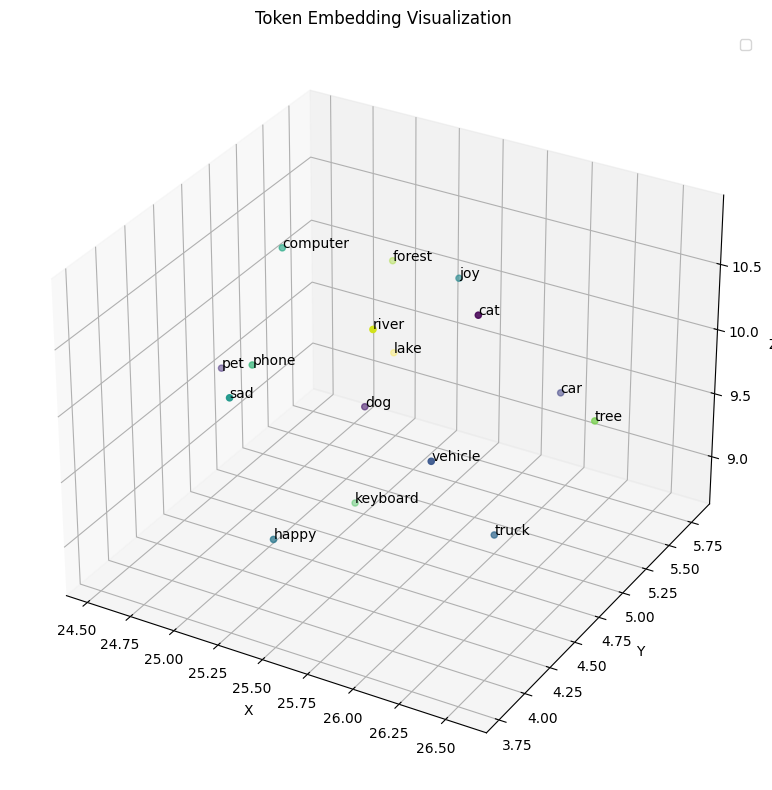

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=range(len(viz_tokens)), cmap='viridis')

# Annotate points with token names
for i, token in enumerate(viz_tokens):
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], token, fontsize=10)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Token Embedding Visualization')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

### Embed prompts
Now let's embed our prompts

In [ ]:
prompt_len = len(tokens)

In [ ]:
# Get token embeddings for given tokens, converting to torch.bfloat16 format
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
print(token_embeddings_unnormalized.shape) # (prompt_len, 4096)

torch.Size([10, 4096])


These embeddings are not normalized, and it will have a serious effect if we don't normalize them. In the next section, we will perform normalization on our input vectors.

## RMSNorm
We will normalize the input vectors using the same formula we have seen earlier for RMSNorm to ensure our inputs are normalized.

![](https://cdn-images-1.medium.com/max/1000/0*GIr8bvByN_iAGQBW.png)

In [ ]:
# Calculating RMSNorm
def rms_norm(tensor, norm_weights):

    # Calculate the mean of the square of tensor values along the last dimension
    squared_mean = tensor.pow(2).mean(-1, keepdim=True)

    # Add a small value to avoid division by zero
    normalized = torch.rsqrt(squared_mean + norm_eps)

    # Multiply normalized tensor by the provided normalization weights
    return (tensor * normalized) * norm_weights

We will use the attention weights from layers_0 to normalize our unnormalized embeddings. The reason for using layer_0 is that we are now creating the first layer of our LLaMA-3 transformer architecture.

In [ ]:
# using RMS normalization and provided normalization weights
token_embeddings = rms_norm(token_embeddings_unnormalized,
                            load_module_weight("model.layers.0.input_layernorm.weight"))
print(token_embeddings.shape) # (prompt_len, 4096)

torch.Size([10, 4096])


You may already know that the dimension won't change because we are only normalizing the vectors and nothing else.

## Self-Attention module

### Attention Heads (Query, Key, Values)
first, let's load the query, key, value and output vectors from the model.

In [ ]:
# Print the shapes of different weights
print(
    # Query weight shape
    load_module_weight("model.layers.0.self_attn.q_proj.weight").shape,

    # Key weight shape
    load_module_weight("model.layers.0.self_attn.k_proj.weight").shape,

    # Value weight shape
    load_module_weight("model.layers.0.self_attn.v_proj.weight").shape,

    # Output weight shape
    load_module_weight("model.layers.0.self_attn.o_proj.weight").shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


The dimensions indicate that the model weights we downloaded are not for each head individually but for multiple attention heads due to implementing a parallel approach/training. However, we can unwrap these matrices to make them available for a single head only.

In [ ]:
# Retrieve query weight for the first layer of attention
q_layer0 = load_module_weight("model.layers.0.self_attn.q_proj.weight")

# Calculate dimension per head
head_dim = q_layer0.shape[0] // n_heads

# Reshape query weight to separate heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
print(q_layer0.shape) # (num_heads, 128, 4096)

torch.Size([32, 128, 4096])


Here, 32 is the number of attention heads in Llama-3, 128 is the size of the query vector, and 4096 is the size of the token embedding.
We can access the query weight matrix of the first head of the first layer using:

In [ ]:
# Extract the query weight for the first head of the first layer of attention
q_layer0_head0 = q_layer0[0]
print(q_layer0_head0.shape) # (128, 4096)

torch.Size([128, 4096])


To find the query vector for each token, we multiply the query weights with the token embedding.

In [ ]:
# Matrix multiplication: token embeddings with transpose of query weight for first head
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
print(q_per_token.shape) # (prompt_len, 128)

torch.Size([10, 128])


The query vectors don't inherently know their position in the prompt, so we'll use RoPE to make them aware of it.

### Implementing RoPE

We split the query vectors into pairs and then apply a rotational angle shift to each pair.

In [ ]:
# Convert queries per token to float and split into pairs
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
print(q_per_token_split_into_pairs.shape) # (prompt_len, 64, 2)

torch.Size([10, 64, 2])


We have a vector of size (prompt_len, 64, 2), which represents the 128-length queries split into 64 pairs for each token in the prompt. Each pair will be rotated by m*theta, where m is the position of the token for which we are rotating the query.
We'll use the dot product of complex numbers to rotate a vector.

In [ ]:
# Generate values from 0 to 1 split into 64 parts
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
print(zero_to_one_split_into_64_parts)

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])


After the splitting step, we are going to calculate the frequency of it.

In [ ]:
# Calculate frequencies using a power operation
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
print(freqs)

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])


Now, with a complex number for each token's query element, we convert our queries into complex numbers and then rotate them based on their position using dot product.

In [ ]:
# Convert queries per token to complex numbers
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
print(q_per_token_split_into_pairs[0][:1]) # (prompt_len, 64)
print(q_per_token_as_complex_numbers[0][0])  # (prompt_len, 64)

# Calculate frequencies for each token using outer product of arange(prompt_len) and freqs
freqs_for_each_token = torch.outer(torch.arange(prompt_len), freqs) ## Get the frequency for each token and dimension
print(freqs_for_each_token.shape) # (prompt_len, 64)

# Calculate complex numbers from frequencies_for_each_token using polar coordinates
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token) ## Rotation angle for each token

# Rotate complex numbers by frequencies
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
print(q_per_token_as_complex_numbers_rotated.shape) # (prompt_len, 64)


tensor([[-0.0757,  0.2734]], grad_fn=<SliceBackward0>)
tensor(-0.0757+0.2734j, grad_fn=<SelectBackward0>)
torch.Size([10, 64])
torch.Size([10, 64])


#### Visualizing RoPE

In [ ]:
# this is a code snippet for plotting RoPE with different depth and positions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow
import torch
from ipywidgets import interact, IntSlider, Output
import ipywidgets as widgets
from IPython.display import display

%matplotlib inline

def visualize_embeddings(original, rotary_base, rotated, dim, tokenizer, tokens):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
    axes = [ax1, ax2, ax3]
    titles = ['Original Embeddings', 'Rotary Embedding Base', 'Rotated Embeddings']
    data = [original, rotary_base, rotated]

    for ax, title, embeddings in zip(axes, titles, data):
        ax.clear()  # Clear the previous plot
        ax.set_aspect('equal')
        ax.grid(True)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)

        # Draw clock face
        circle = plt.Circle((0, 0), 1, fill=False)
        ax.add_artist(circle)
        for i in range(12):
            angle = i * 30 * np.pi / 180
            ax.plot([0, np.cos(angle)], [0, np.sin(angle)], 'k--', alpha=0.3)

        # Plot vectors
        num_tokens = min(10, embeddings.shape[0])  # Limit to first 10 tokens for clarity
        colors = plt.cm.rainbow(np.linspace(0, 1, num_tokens))

        for i in range(num_tokens):
            x = embeddings[i, 0].real.item()
            y = embeddings[i, 0].imag.item()
            color = colors[i]
            ax.add_patch(Arrow(0, 0, x, y, width=0.02, color=color, alpha=0.7))
            ax.text(x*1.1, y*1.1, tokenizer.decode([tokens[i]]), ha='center', va='center', color=color, fontweight='bold')

        ax.set_title(f"{title} (Dimension {dim})")

    # plt.tight_layout()

out = Output()
@out.capture()
def interactive_plot(original_embeddings, rotary_base, rotated_embeddings, tokenizer, tokens):
    max_dim = original_embeddings.shape[1] - 1

    def update(dim):
        visualize_embeddings(
            original_embeddings[:, dim:dim+1],
            rotary_base[:, dim:dim+1],
            rotated_embeddings[:, dim:dim+1],
            dim,
            tokenizer,
            tokens
        )
        plt.show()

    widgets.interact(update, dim=widgets.IntSlider(min=0, max=max_dim, step=1, value=0, description='Dimension:'))

# Assuming you have these variables defined:
original_embeddings = q_per_token_as_complex_numbers
rotary_base = freqs_cis
rotated_embeddings = q_per_token_as_complex_numbers * freqs_cis

# Call this function to create the interactive plot
display(out)
interactive_plot(original_embeddings, rotary_base, rotated_embeddings, tokenizer, tokens)

Output()

After obtaining the rotated vector, we can revert back to our original queries as pairs by viewing the complex numbers as real numbers again.

In [ ]:
# Convert rotated complex numbers back to real numbers
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)

# Print the shape of the resulting tensor
q_per_token_split_into_pairs_rotated.shape

torch.Size([10, 64, 2])

The rotated pairs are now merged, resulting in a new query vector (rotated query vector) that has the shape (prompt_len, 128), where 128 is the dimension of the query vector.

In [ ]:
# Reshape rotated token queries to match the original shape
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

# Print the shape of the resulting tensor
q_per_token_rotated.shape

torch.Size([10, 128])

For keys, the process is similar, but keep in mind that key vectors are also 128-dimensional. Keys have only 1/4th the number of weights as queries because they are shared across 4 heads at a time to minimize computations. Keys are also rotated to include positional information, similar to queries.

In [ ]:
# Extract the weight tensor for the attention mechanism's key in the first layer of the model
k_layer0 = load_module_weight("model.layers.0.self_attn.k_proj.weight")

# Reshape key weight for the first layer of attention to separate heads
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
print(k_layer0.shape) # (8, 128, 4096)

# Extract the key weight for the first head of the first layer of attention
k_layer0_head0 = k_layer0[0]
print(k_layer0_head0.shape)  # (128, 4096)

# Calculate key per token by matrix multiplication
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
print(k_per_token.shape)  # (prompt_len, 128)

# Split key per token into pairs and convert to float
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
print(k_per_token_split_into_pairs.shape)  # (prompt_len, 64, 2)

# Convert key per token to complex numbers
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
print(k_per_token_as_complex_numbers.shape) # (prompt_len, 64)

# Rotate complex key per token by frequencies
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)

# Print the shape of the rotated complex key per token
k_per_token_split_into_pairs_rotated.shape  # Output: torch.Size([prompt_len, 64, 2])

# Reshape rotated key per token to match the original shape
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
print(k_per_token_rotated.shape) # (prompt_len, 128)

torch.Size([8, 128, 4096])
torch.Size([128, 4096])
torch.Size([10, 128])
torch.Size([10, 64, 2])
torch.Size([10, 64])
torch.Size([10, 128])


In [ ]:
# Retrieve the value weight for the first layer of attention, this is for making the next section more smooth.
v_layer0 = load_module_weight("model.layers.0.self_attn.v_proj.weight")

# Reshape value weight for the first layer of attention to separate heads
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
print(v_layer0.shape) # (8, 128, 4096)
# Extract the value weight for the first head of the first layer of attention
v_layer0_head0 = v_layer0[0]
print(v_layer0_head0.shape) # (128, 4096)

# Calculate value per token by matrix multiplication
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
print(v_per_token.shape) # (prompt_len, 128)

torch.Size([8, 128, 4096])
torch.Size([128, 4096])
torch.Size([10, 128])


We now have the rotated queries and keys for each token, with each being of size (prompt_len, 128).

### TODO 1 - Single head attention

#### Recap

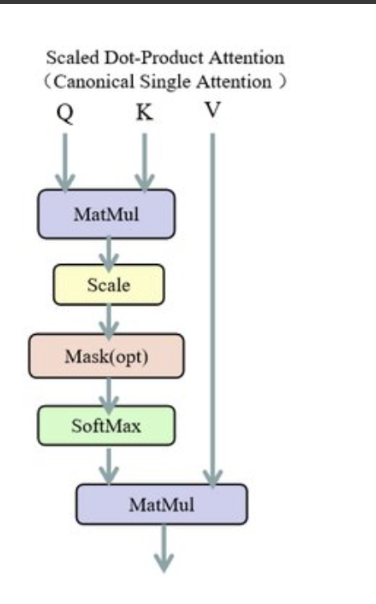

Attention mechanism was proposed in [Attention is all you need](https://arxiv.org/pdf/1706.03762).

This mechanism allows LLM to selectively attend to different parts of input text.
The attention mechanism computes the attention weights (how much we should attentd to one part of the input) by measuring the similarity (dot product) between the query and the keys. The values are then weighted by the attention weights and combined to produce the final output of the attention mechanism.

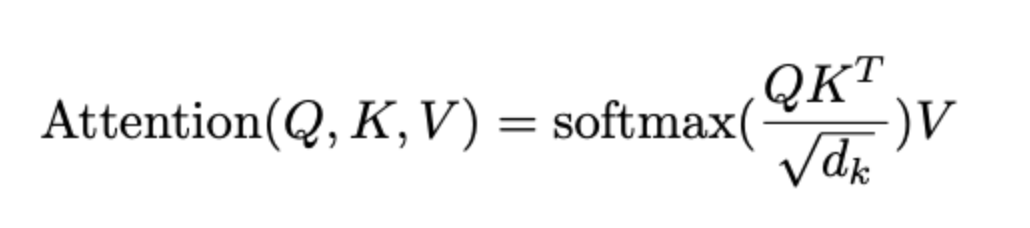

In this TODO, we will realize this formula step by step,
1. QK matrix multiplication: derive the unnormalized attention weight
2. scaled and softmax: derive the 0-1 probability
3. compute the attention output: derive output by assigning different V with attention weights

#### (1-1) Compute Q and K

In [ ]:
## We will start by calculating similarity between Q and K.
## q_per_token_rotated -> Q
## k_per_token_rotated -> K

# TODO 1-1: Compute Q(K.T) matrix multiplication
qk_per_token =
print(qk_per_token.shape) ## your output should be ([token_len,token_len])
print(qk_per_token)

torch.Size([10, 10])
tensor([[ 11.4479,  -4.1105,  -3.8678,  -8.4197, -13.4337, -19.9065, -13.0498,
         -12.5076,  -9.7084, -15.0782],
        [ 25.7426,  -3.4930, -27.2487, -32.8046, -47.2528, -55.9145, -38.3004,
         -32.3618, -20.9183, -42.5390],
        [ 21.9852, -47.8893,  -5.4096, -10.5724, -39.2348, -73.6150, -71.2243,
         -76.7680, -47.8613, -47.5007],
        [  7.7314, -80.2166, -34.3020, -13.2043, -23.2753, -48.1211, -66.5193,
         -88.0660, -57.5897, -58.0146],
        [  8.5806, -48.5645, -31.9186, -19.7255, -10.6553, -15.2242, -26.0849,
         -40.0397, -39.4801, -54.3271],
        [  4.0151, -52.8908, -55.1465, -47.4607, -37.9957, -19.9962, -19.3024,
         -23.7862, -41.0774, -73.0196],
        [  9.0454, -36.0905, -33.6601, -34.3695, -34.7710, -31.2113,  -6.9521,
          -7.8172,  -8.0342, -41.5321],
        [  9.9245, -21.5995, -27.5412, -27.4226, -34.1755, -30.7363, -14.1517,
           0.3500,   5.0962, -18.9832],
        [ -0.3087, -45.6346

#### Scale QK Matrix (dot product)
Scaling the product by dimension prevents the value of product from exploding, which we inevitably leads to problem when calculating softmax score. For detail explanation, we encourge you to refer to [Why do we scaled products](https://medium.com/@funcry/in-depth-understanding-of-attention-mechanism-part-ii-scaled-dot-product-attention-and-its-7743804e610e).

In [ ]:
scaled_factor = (head_dim) ** 0.5
## Scale the product by scaled_factor
qk_per_token = qk_per_token / scaled_factor

print(qk_per_token.shape) ## ([token_len,token_len])

torch.Size([10, 10])


#### (1-2) Mask QK Matrix
For each token, it is only nature that it can refers to previously generated tokens but not those in the future. Thus, we should not give any weight on them in the QK matrix.

We will construct a matrix where positions for valid tokens are 0 and negative infinity otherwise.

In [ ]:
# TODO 1-2:
## Hint: We need to set invalid places in QK to -inf.
# 1, create a mask tensor filled with negative infinity values
mask =

# 2. set upper triangular part of the mask tensor to negative infinity
mask =

# Print the resulting mask tensor
print(mask) ## (a 2 dimension matrix, with -inf on the upper traingle)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [ ]:
# apply attention mask on qk matrix
qk_per_token_after_masking = qk_per_token + mask
print(qk_per_token_after_masking)

tensor([[ 1.0119,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [ 2.2753, -0.3087,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [ 1.9432, -4.2329, -0.4781,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [ 0.6834, -7.0902, -3.0319, -1.1671,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [ 0.7584, -4.2925, -2.8212, -1.7435, -0.9418,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [ 0.3549, -4.6749, -4.8743, -4.1950, -3.3584, -1.7674,    -inf,    -inf,
            -inf,    -inf],
        [ 0.7995, -3.1900, -2.9752, -3.0379, -3.0733, -2.7587, -0.6145,    -inf,
            -inf,    -inf],
        [ 0.8772, -1.9091, -2.4343, -2.4238, -3.0207, -2.7167, -1.2508,  0.0309,
            -inf,    -inf],
        [-0.0273, -4.0336, -2.1684, -1.8109, -2.9446, -2.8232, -2.1174, -1.5004,
          0.9390,    -inf],
        [-0.3247, -

#### (1-3) Softmax QK Matrix
Next, we will apply a softmax function. A max function only retruns the max value along some dimension, which means we can only attend to "one" value of previosly generated tokens.

We don't want that. Instead, we would like every tokens that might potentially be helpful to the calculation contributes, more or less. This is where softmax come in handy.

Note that since tokens in the future are all assigned negative infinity in the QK matrix. We ensure that the model cannot peak into the future and cheat.

In [ ]:
# TODO 1-3 softmax qk matrix to get attention map
qk_per_token_after_masking_after_softmax =
print(qk_per_token_after_masking_after_softmax) # Your attention map should sum up to one for every row!

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.2969e-01, 7.0312e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.1797e-01, 1.9073e-03, 8.1543e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.4766e-01, 3.5667e-04, 2.0630e-02, 1.3281e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.6953e-01, 4.9438e-03, 2.1484e-02, 6.2988e-02, 1.4062e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.5547e-01, 5.6152e-03, 4.5776e-03, 9.0332e-03, 2.0874e-02, 1.0254e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.3828e-01, 1.3672e-02, 1.6968e-02, 1.5869e-02, 1.5320e-02, 2.0996e-02,
         1.7969e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.7812e-01, 3.5645

#### (1-4) Compute values
Finally, the "computed,scaled,masked,softmaxed" matrix, which contains the information about how the model think the helpfulness of each tokens, are multiplied by each tokens' correponding value.

In [ ]:
# v_per_token -> V

# TODO 1-4: Apply attention weight on value matrix to generate final attention output
qkv_attention =
print(qkv_attention.shape) # (prompt_len, 128)
print(qkv_attention)

torch.Size([10, 128])
tensor([[ 0.0154,  0.0008,  0.0334,  ..., -0.0248, -0.0028,  0.0649],
        [ 0.0121, -0.0035,  0.0278,  ..., -0.0243, -0.0012,  0.0554],
        [ 0.0150,  0.0031,  0.0327,  ..., -0.0228,  0.0018,  0.0618],
        ...,
        [ 0.0084,  0.0073,  0.0205,  ..., -0.0197, -0.0087,  0.0286],
        [ 0.0057,  0.0102,  0.0378,  ..., -0.0033, -0.0090,  0.0439],
        [ 0.0195, -0.0034,  0.0110,  ..., -0.0151,  0.0181,  0.0493]],
       dtype=torch.bfloat16, grad_fn=<MmBackward0>)


In [ ]:
# @title TODO-1 answer
# Calculate scaled query-key dot products per token
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T) / (head_dim) ** 0.5
assert (qk_per_token.shape == (prompt_len, prompt_len))

# Create a mask tensor filled with negative infinity values
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)

# Set upper triangular part of the mask tensor to negative infinity
mask = torch.triu(mask, diagonal=1)
print(mask)

# Add the mask to the query-key dot products per token
qk_per_token_after_masking = qk_per_token + mask

# Apply softmax along the second dimension after masking
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

# Retrieve the value weight for the first layer of attention
v_layer0 = load_module_weight("model.layers.0.self_attn.v_proj.weight")

# Reshape value weight for the first layer of attention to separate heads
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)

# Extract the value weight for the first head of the first layer of attention
v_layer0_head0 = v_layer0[0]

# Calculate value per token by matrix multiplication
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.sum()

# Calculate QKV attention by matrix multiplication
official_qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
print(official_qkv_attention)
assert((v_layer0.shape) ==  (8, 128, 4096))
assert((v_layer0_head0.shape) == (128, 4096))
assert((v_per_token.shape) == (prompt_len, 128))
assert((official_qkv_attention.shape) == (prompt_len, 128))

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[ 0.0154,  0.0008,  0.0334,  ..., -0.0248, -0.0028,  0.0649],
        [ 0.0121, -0.0035,  0.0278,  ..., -0.0243, -0.0012,  0.0554],
        [ 0.0150,  0.0031,  0.0327,  ..., -0.0228,  0.0018,  0.0618],
        ...,
        [ 0.0084,  0.0073,  0.0205,  ..., -0.0197, -0.0087,  0.0286],
        [ 0.0057,  0.0102,  0.0378,  ..., -0.0033, -0.0090,  0.0439],
        [ 0.0195, -0.0034,  0.0110,  ..., -0.0

In [ ]:
assert(torch.equal(qkv_attention.sum(),official_qkv_attention.sum()))

We now have the attention values for the first layer and first head or in other words self attention.

### Implementing Multi-Head Attention

A loop will be executed to perform the same calculations as above, but for every head in the first layer.

In [ ]:
# Store QKV attention for each head in a list
qkv_attention_store = []

# Iterate through each head
for head in range(n_heads):
    # Extract query, key, and value weights for the current head
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4]  # Key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4]  # Value weights are shared across 4 heads

    # Calculate query per token by matrix multiplication
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)

    # Calculate key per token by matrix multiplication
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)

    # Calculate value per token by matrix multiplication
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    # Split query per token into pairs and rotate them
    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    # Split key per token into pairs and rotate them
    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    # Calculate query-key dot products per token
    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T) / (128) ** 0.5

    # Create a mask tensor filled with negative infinity values
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    # Set upper triangular part of the mask tensor to negative infinity
    mask = torch.triu(mask, diagonal=1)
    # Add the mask to the query-key dot products per token
    qk_per_token_after_masking = qk_per_token + mask

    # Apply softmax along the second dimension after masking
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

    # Calculate QKV attention by matrix multiplication
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)

    # Store QKV attention for the current head
    qkv_attention_store.append(qkv_attention)

# Print the number of QKV attentions stored
len(qkv_attention_store)

Now that the QKV attention matrix for all 32 heads in the first layer is obtained, all attention scores will be merged into one large matrix of size (prompt_len, 4096)

In [ ]:
# Concatenate QKV attentions from all heads along the last dimension
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)

# Print the shape of the resulting tensor
stacked_qkv_attention.shape

One of the last steps for layer 0 attention is to multiply the weight matrix with the stacked QKV matrix.

In [ ]:
# Calculate the embedding delta by matrix multiplication with the output weight
embedding_delta = torch.matmul(stacked_qkv_attention, load_module_weight("model.layers.0.self_attn.o_proj.weight").T)
print(embedding_delta.shape) # (prompt_len, 4096)

We now have the change in the embedding values after attention, which should be added to the original token embeddings.

In [ ]:
# Add the embedding delta to the unnormalized token embeddings to get the final embeddings
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
print(embedding_after_edit.shape) # (prompt_len, 4096)

The change in embeddings is normalized, followed by running it through a feedforward neural network.

In [ ]:
# Normalize edited embeddings using root mean square normalization and provided weights
embedding_after_edit_normalized = rms_norm(embedding_after_edit, load_module_weight("model.layers.0.post_attention_layernorm.weight"))
print(embedding_after_edit_normalized.shape) # (prompt_len, 4096)

## SwiGLU Activation Function
Given our familiarity with the SwiGLU activation function from the previous section, we will apply the equation here.

![](https://cdn-images-1.medium.com/max/1000/1*q5FbOgDpo6H-86AefVzdNQ.png)

In [ ]:
# Retrieve weights for feedforward layer
w1 = load_module_weight("model.layers.0.mlp.gate_proj.weight")
w2 = load_module_weight("model.layers.0.mlp.down_proj.weight")
w3 = load_module_weight("model.layers.0.mlp.up_proj.weight")

# Perform operations for feedforward layer
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
print(output_after_feedforward.shape) # (prompt_len, 4096)

## Merging everything
Now that everything is ready, we need to merge our code to generate 31 more layers.

In [ ]:
from tqdm.notebook import tqdm
# Initialize final embedding with unnormalized token embeddings
final_embedding = token_embeddings_unnormalized

# Iterate through each layer
for layer in tqdm(range(n_layers), desc='layers'):
    # Initialize list to store QKV attentions for each head
    qkv_attention_store = []
    # Normalize the final embedding using root mean square normalization and weights from the current layer
    layer_embedding_norm = rms_norm(final_embedding, load_module_weight(f"model.layers.{layer}.input_layernorm.weight"))
    # Retrieve query, key, value, and output weights for the attention mechanism of the current layer
    q_layer = load_module_weight(f"model.layers.{layer}.self_attn.q_proj.weight")
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = load_module_weight(f"model.layers.{layer}.self_attn.k_proj.weight")
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = load_module_weight(f"model.layers.{layer}.self_attn.v_proj.weight")
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = load_module_weight(f"model.layers.{layer}.self_attn.o_proj.weight")

    # Iterate through each head
    for head in range(n_heads):
        # Extract query, key, and value weights for the current head
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]  # Key weights are shared across 4 heads
        v_layer_head = v_layer[head//4]  # Value weights are shared across 4 heads

        # Calculate query per token by matrix multiplication
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)

        # Calculate key per token by matrix multiplication
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)

        # Calculate value per token by matrix multiplication
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)

        # Split query per token into pairs and rotate them
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

        # Split key per token into pairs and rotate them
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

        # Calculate query-key dot products per token
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T) / (128) ** 0.5

        # Create a mask tensor filled with negative infinity values
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        # Set upper triangular part of the mask tensor to negative infinity
        mask = torch.triu(mask, diagonal=1)
        # Add the mask to the query-key dot products per token
        qk_per_token_after_masking = qk_per_token + mask

        # Apply softmax along the second dimension after masking
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

        # Calculate QKV attention by matrix multiplication
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)

        # Store QKV attention for the current head
        qkv_attention_store.append(qkv_attention)

    # Concatenate QKV attentions from all heads along the last dimension
    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)

    # Calculate embedding delta by matrix multiplication with the output weight
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)

    # Add the embedding delta to the current embedding to get the edited embedding
    embedding_after_edit = final_embedding + embedding_delta

    # Normalize the edited embedding using root mean square normalization and weights from the current layer
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, load_module_weight(f"model.layers.{layer}.post_attention_layernorm.weight"))

    # Retrieve weights for the feedforward layer
    w1 = load_module_weight(f"model.layers.{layer}.mlp.gate_proj.weight")
    w2 = load_module_weight(f"model.layers.{layer}.mlp.down_proj.weight")
    w3 = load_module_weight(f"model.layers.{layer}.mlp.up_proj.weight")

    # Perform operations for the feedforward layer
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)

    # Update the final embedding with the edited embedding plus the output from the feedforward layer
    final_embedding = embedding_after_edit + output_after_feedforward

## Generating the Output
We now have the final embedding, representing the model's guess for the next token. Its shape is the same as regular token embeddings, (prompt_len, 4096).

In [ ]:
# Normalize the final embedding using root mean square normalization and provided weights
final_embedding = rms_norm(final_embedding, load_module_weight('model.norm.weight'))
print(final_embedding.shape) # (prompt_len, 4096)

Now we can decode the embedding into the token value.


In [ ]:
print(load_module_weight(f"lm_head.weight").shape) # (vocab_size, 4096)

To predict the next value, we utilize the embedding of the last token.

In [ ]:
# Calculate logits by matrix multiplication between the final embedding and the transpose of the output weight tensor
logits = torch.matmul(final_embedding[-1], load_module_weight(f"lm_head.weight").T)

# Find the index of the maximum value along the last dimension to determine the next token
next_token = torch.argmax(logits, dim=-1)

# Decode the index of the next token using the tokenizer
tokenizer.decode([next_token.item()])

## TODO 2 - greedy decoding
Hint:
  1. select the most probable token in each forward pass
  2. append this toekn to previous generated tokens
  3. autoregressively do so

In [ ]:
from tqdm.notebook import tqdm
prompt = "Life was like a box of chocolates. You"
tokens = tokenizer.encode(prompt)
# iterate number of decoding steps
for step in tqdm(range(5), desc="Decoding step"):
  prompt_len = len(tokens)
  # model forward to get the next_token
  next_token =
  # append new token to prompt
  tokens = tokens.tolist() + [next_token.item()]


print(tokenizer.decode(tokens))

In [ ]:
# @title TODO-2 answer
from tqdm.notebook import tqdm
prompt = "Life was like a box of chocolates. You"
tokens = tokenizer.encode(prompt)
# iterate number of decoding steps
for step in tqdm(range(5), desc="Decoding step"):
  prompt_len = len(tokens)
  tokens = torch.tensor(tokens)
  token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
  # Initialize final embedding with unnormalized token embeddings
  final_embedding = token_embeddings_unnormalized
  # Iterate through each layer
  for layer in tqdm(range(n_layers), desc='layers', leave=False):
    # Initialize list to store QKV attentions for each head
    qkv_attention_store = []
    # Normalize the final embedding using root mean square normalization and weights from the current layer
    layer_embedding_norm = rms_norm(final_embedding, load_module_weight(f"model.layers.{layer}.input_layernorm.weight"))
    # Retrieve query, key, value, and output weights for the attention mechanism of the current layer
    q_layer = load_module_weight(f"model.layers.{layer}.self_attn.q_proj.weight")
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = load_module_weight(f"model.layers.{layer}.self_attn.k_proj.weight")
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = load_module_weight(f"model.layers.{layer}.self_attn.v_proj.weight")
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = load_module_weight(f"model.layers.{layer}.self_attn.o_proj.weight")

    # Iterate through each head
    for head in range(n_heads):
      # Extract query, key, and value weights for the current head
      q_layer_head = q_layer[head]
      k_layer_head = k_layer[head//4]  # Key weights are shared across 4 heads
      v_layer_head = v_layer[head//4]  # Value weights are shared across 4 heads

      # Calculate query/key/value per token by matrix multiplication
      q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
      k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
      v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)

      # Calculate frequencies for each token using outer product of arange(prompt_len) and freqs
      freqs_for_each_token = torch.outer(torch.arange(prompt_len), freqs)
      # Calculate complex numbers from frequencies_for_each_token using polar coordinates
      freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)

      # Split query/key per token into pairs and rotate them
      q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
      q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
      q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
      q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

      k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
      k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
      k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
      k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

      # Calculate query-key dot products per token
      qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T) / (128) ** 0.5

      # Create a mask tensor filled with negative infinity values
      mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
      # Set upper triangular part of the mask tensor to negative infinity
      mask = torch.triu(mask, diagonal=1)
      # Add the mask to the query-key dot products per token
      qk_per_token_after_masking = qk_per_token + mask

      # Apply softmax along the second dimension after masking
      qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

      # Calculate QKV attention by matrix multiplication
      qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)

      # Store QKV attention for the current head
      qkv_attention_store.append(qkv_attention)

    # Concatenate QKV attentions from all heads along the last dimension
    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)

    # Calculate embedding delta by matrix multiplication with the output weight
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)

    # Add the embedding delta to the current embedding to get the edited embedding
    embedding_after_edit = final_embedding + embedding_delta

    # Normalize the edited embedding using root mean square normalization and weights from the current layer
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, load_module_weight(f"model.layers.{layer}.post_attention_layernorm.weight"))

    # Retrieve weights for the feedforward layer
    w1 = load_module_weight(f"model.layers.{layer}.mlp.gate_proj.weight")
    w2 = load_module_weight(f"model.layers.{layer}.mlp.down_proj.weight")
    w3 = load_module_weight(f"model.layers.{layer}.mlp.up_proj.weight")

    # Perform operations for the feedforward layer
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)

    # Update the final embedding with the edited embedding plus the output from the feedforward layer
    final_embedding = embedding_after_edit + output_after_feedforward

  # Normalize the final embedding using root mean square normalization and provided weights
  final_embedding = rms_norm(final_embedding, load_module_weight('model.norm.weight'))

  # Calculate logits by matrix multiplication between the final embedding and the transpose of the output weight tensor
  logits = torch.matmul(final_embedding[-1], load_module_weight(f"lm_head.weight").T)

  # Find the index of the maximum value along the last dimension to determine the next token
  next_token = torch.argmax(logits, dim=-1)

  # append new token to prompt
  tokens = tokens.tolist() + [next_token.item()]
  print(tokenizer.decode(tokens))


In [ ]:
print(tokenizer.decode(tokens))